In [1]:
# This is always required for inline plot rendering in IPython Notebooks, 
# so might as well do it first, even before the markdown sections
%matplotlib inline
#%matplotlib notebook

Geomag-IMP Verification and Demonstration
=========================================

This IPython Notebook verifies that the Geomag-IMP module and associated classes work as intended, and demonstrates its usage for both simple and realistic scenarios. It offers examples for unit tests, but is not intended to replace them. It offers similar useage examples to those found in the command line scripts, but is not intended to replace these. It is intended primarily for the technical review required for official USGS software releases.

# Contents:
- [Background and Motivation](#Background-and-Motivation)
- [Theoretical Basis](#Theoretical-Basis)
- [Putting it All Together](#Putting-it-All-Together)
- [Functional Tests](#Functional-Tests)
  - [Imports](#Imports)
  - [Compare SECs Results with A&V-1999](#Compare-SECs-Results-with-A&V-1999)
  - [Fitting SECs to Synthetic Data](#Fitting-SECs-to-Synthetic-Data)

# [Background and Motivation](#Contents:)

The USGS Geomagnetism Program Interpolated Magnetic Perturbation (Geomag-IMP) Python library is primarily for interpolating magnetic field perturbations onto arbitrary geograhic coordinates. It provides two (for now) classes for interpolating magnetic fields. The first is just a thin wrapper for the Gaussian Process regressor found in the Scikit-Learn machine learning package. This is a kind of optimal interpolation, with little or no physical basis, and has been tested and validated by the scientific Python community; it will not be discussed further here.

The second Python class is an adaptation of the technique first described by Olaf Amm and Ari Viljanen in their 1999 *Earth Planets Space* article "Ionospheric disturbance magnetic field continuation from the ground to ionosphere using spherical elementary current systems" (A&V-1999). Very briefly, so-called spherical elementary currents (SECs) provide basis fucntions defined by geographic position and amplitude. A given system, often gridded, of these SECs generates a unique interpolated magnetic field by applying Ampere's Law in spherical coordinates.

Traditional 2D basis function inversion methods, usually based on a spherical harmonic expansion of the global magnetic field, cannot be easily adapted to interpolate between measurements made over a more localized area. In order to reproduce continential-to-regional scale magnetic variations, a high density of evenly distributed measurements is required more-or-less globally. "Spherical cap" harmonic expansion is a direct adaptation of the more traditional method that can and has been used to interpolate magnetic fields over more localized areas, but it requires careful manipulation of a cap's boundary conditions in order to generate a realistic fit. 

SEC-based interpolation can be applied to arbitrary, often much more localized measurements, using a simpler and more physically intuitive set of basis functions. In fact, many of the studies using SEC systems over the years have been more focused on the toroidal ionospheric equivalent currents generated by SEC inversions than on ground magnetic disturbance. But while these are only equivalent currents (the real ionospheric current distribution is 3D, and more complex), the resultant ground magnetic fields are essentially equivalent (thus the term "equivalent current").

# [Theoretical Basis](#Contents:)
The reader should refer to A&V-1999, and numerous subsequent publications, for more details on the underlying theory and math. A minimal description is provided here in support of these validation results.

An SEC describes a special electrical current distribution on a thin spherical shell that can be fully specified with a single scalar value $I$. There are two kinds of SECs: curl free, and divergence free. The curl free type is undetectable from inside the spherical shell, so we ignore it for now (we may revisit this in the future). Adapted from A&V-1999, the following figure provides an schematic view of both types of SEC (with emphasis on the divergence free):

![alt text](./images/SECs.png)

The divergence free SEC possesses a toroidal current density that diminishes from a peak amplitude at the SEC "north" pole, to zero at the SEC "south" pole, following a relatively simple trigonometric function of polar angle ($\theta$):

<a name="eq01">(1)</a>&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;
$\displaystyle
J_{\hat{\phi}} = \frac{I_0}{4\pi R} 
\left(  \frac{1+\cos{\theta}}{\sin{\theta}} \right)
$

where

$\begin{array}{rcl}
J         & \text{is} & \text{current density}            \\ 
\theta    & \text{is} & \text{colatitude, or polar angle} \\
\phi      & \text{is} & \text{longitude}                  \\
R         & \text{is} & \text{SEC radius}                 \\ 
\end{array}
$

These toroidal currents generate poloidal magnetic fields, which can be calculated analytically both above and below the divergence free SEC:

<a name="eq02">(2)</a>&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;
$\begin{array}{rcl}
B_{\hat{r}} & = & 
\frac{I_g \mu_0}{4\pi r} 
  \frac{R_g}{r}
\left(  
    \frac{1}{\sqrt{1 - \frac{2 R_g \cos{\theta}}{r} +
                   \left( \frac{R_g}{r} \right)^2}} - 1
  \right) + \\
& & \frac{I_i \mu_0}{4\pi r} 
\left(  
    \frac{1}{\sqrt{1 - \frac{2 r \cos{\theta}}{R_i} + 
                   \left( \frac{r}{R_i} \right)^2}} - 1
\right) \\
\end{array}
$

<a name="eq03">(3)</a>&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;
$\begin{array}{rcl}
B_{\hat{\theta}} & = & 
- \frac{I_g \mu_0}{4\pi r \sin{\theta}} 
\left(  
  \frac{r - R_g \cos{\theta}}
       {\sqrt{r^2 - 2 r R_g \cos{\theta} + R_g^2}} - 1
\right) + \\
& & - \frac{I_i \mu_0}{4\pi r \sin{\theta}} 
\left(  
  \frac{\frac{r}{R_i} - cos{\theta}}
  {\sqrt{1 - \frac{2 r \cos{\theta}}{R_i} + 
                 \left( \frac{r}{R_i} \right)^2}} + \cos{\theta}
\right) \\
\end{array}
$

where

$\begin{array}{rcl}
B_{\hat{r}}      & \text{is} & \text{radial magnetic field}    \\
B_{\hat{\theta}} & \text{is} & \text{southward magnetic field} \\
r                & \text{is} & \text{radius at B location} \\
\theta           & \text{is} & \text{colatitude at B location} \\
R_i       & \text{is} & \text{radius of SEC} > r     \\
R_g       & \text{is} & \text{radius of SEC} < r     \\
I_i       & \text{is} & \text{amplitude of SEC} > r     \\
I_g       & \text{is} & \text{amplitude of SEC} < r     \\
\mu_0     & \text{is} & \text{permiability of free space} \\
\end{array}
$

While these equations only generate magnetic fields in the radial and southward directions within the spherical reference frame of a particular SEC, they produce an eastward component when transformed into other local spherical coordinates. 

# [Putting it All Together](#Contents:)

The Geomag-IMP software implements the above equations, and efficiently applies the coordinate transformations required to generate a regression matrix from a system of geographically distributed 1-amp SECs. These are then scaled (or inverted) to fit actual ground magnetic measurements using singular value decomposition. SVD is used because it allows a simple form of regularization, necessary to accommodate the fact that there are almost always more SECs in a desired system than there are available measurements (i.e., the system is underdetermined). Finally, with a system of properly scaled SEC basis functions, it is straight-forward to calculate magnetic perturbation at arbitrary locations by summing up the contributions of each SEC (transformed to the local spherical coordinates, of course).

The theory and mathematics describe above were implemented in Python following the template for generalized "regressors" used in the well-known ScikitLearn machine learning package. Some details of this API can be found in [README.md](https://github.com/usgs/geomag-imp/blob/master/README.md), but the code's docstrings contain most of the detailed information.

A set of command line tools were also provided. For now, these tools are mostly offered as examples for those who might wish to implement Geomag-IMP locally. They are mostly configured in-script, but since Python is an interpreted language, this should not be a major hinderance to usage. These are also described in [README.md](https://github.com/usgs/geomag-imp/blob/master/README.md).

# [Functional Tests](#Contents:)

The purpose of this section is to demonstrate that the algorithm works as expected, and to a lesser extent, demonstrate its utility with realistic usage examples. While some material here might be extracted to generate unit tests for the algorithm, these are primarily functional tests, and may be more complex than one might want to incorporate into an automated testing framework. Explanatory markdown, inline comments, or both, should tie different tests to the Algorithm Theoretical Basis above as much as possible.

## [Imports](#Contents:)

In [2]:
# import standard modules
import numpy as np
import matplotlib.pyplot as plt
import cPickle
import os
import copy as cp

# import geomag_imp
import geomag_imp

In [3]:
# modify default plot properties
from cycler import cycler
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cycler('color', ['r', 'g', 'b', 'm', 'y', 'c']))

## [Compare SECs Results with A&V-1999](#Contents:)

A&V-1999 contained a figure of sample magnetic disturbance as a function of angle/distance from the pole of a single SEC 100km above the Earth's surface. As expected, there are radial and poloidal magnetic deflections, but not zonal.

We start by reproducing this one idealized case, then one counter-case where the SEC is located 100km below the Earth's surface, and finally, a case where there are two SECs, directly above and below the same point on Earth's surface, respectively.

In [4]:
# create simple secs above Earth's surface
lats = np.array([90])
lons = np.array([0])
rads = np.array([6378000 + 100000])
secs_llr = np.array(zip(lats, lons, rads))
secs = geomag_imp.secs(secs_llr)

In [5]:
# predict B-field at Earth's surface (like Figure 2 in A&V-1999)
secsR = geomag_imp.secsRegressor(secs, 0.1)
lats = np.linspace(90,0,901)
lons = np.zeros(lats.shape)
rads = np.zeros(lats.shape) + 6378000
pred_llr = np.array(zip(lats, lons, rads))
amps = 1e4
pred = secsR.predict(pred_llr, amps)

/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:563: RuntimeWarning: invalid value encountered in divide
  arg_tan = y_dot / x_dot
/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:587: RuntimeWarning: divide by zero encountered in divide
  TX2_dot[idx_s] = (-fact * 1 / (x3[idx_s] * np.sin(theta_dot[idx_s])) *


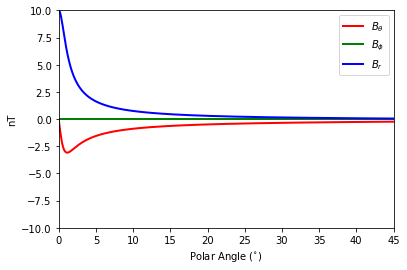

In [6]:
# generate plot similar to A&V-1999
plt.figure()
plt.plot(90-lats, pred * 1e9, linewidth=2)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

In [7]:
# For unit tests, estimate Btheta at 90 degrees colatitude, and Brad at 0 degrees colatitude
mu0 = 4 * np.pi * 1e-7 # N / A^2
Btheta90 = -(mu0 * 1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        (((6378000./(6378000+100000)) - np.cos(np.pi/2)) / \
         np.sqrt(1 - (2. * 6378000. * np.cos(np.pi/2)) / (6378000+100000) + \
                 (6378000/(6378000.+100000.))**2) + np.cos(np.pi/2))
Brad0 = (mu0 * 1e4) / (4. * np.pi * 6378000.) * \
       (1. / (np.sqrt(1. - 2. * 6378000 * np.cos(0.) / (6378000.+100000) + \
                     (6378000 / (6378000.+100000.))**2)) - 1. )

print Btheta90 * 1e9
print pred[-1,0] * 1e9
print Brad0 * 1e9
print pred[0,2] * 1e9

-0.110000838606
-0.110000838606
10.0
10.0


Now, place the SEC 100km below the Earth's surface, and predict magnetic disturbance.

In [8]:
# create simple secs below Earth's surface
lats = np.array([90])
lons = np.array([0])
rads = np.array([6378000. - 100000.])
secs_llr = np.array(zip(lats, lons, rads))
secs = geomag_imp.secs(secs_llr)

In [9]:
# predict B-field at Earth's surface (NOT like Figure 2 in A&V-1999)
secsR = geomag_imp.secsRegressor(secs, 0.1)
lats = np.linspace(90,0,901)
lons = np.zeros(lats.shape)
rads = np.zeros(lats.shape) + 6378000
pred_llr = np.array(zip(lats, lons, rads))
amps = 1e4
pred = secsR.predict(pred_llr, amps)

/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:605: RuntimeWarning: divide by zero encountered in divide
  TX2_dot[idx_f] = (-fact * 1 / (x3[idx_f] * np.sin(theta_dot[idx_f])) *
/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:610: RuntimeWarning: invalid value encountered in multiply
  1))


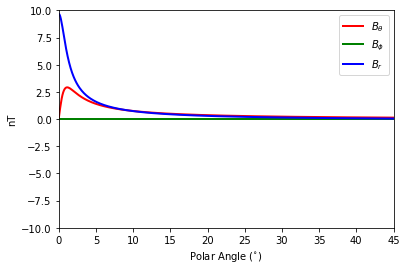

In [10]:
# generate plot similar to A&V-1999
plt.figure()
plt.plot(90-lats, pred * 1e9, linewidth=2)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

In [11]:
# For unit tests, estimate Btheta at 90 degrees colatitude, and Brad at 0 degrees colatitude
mu0 = 4 * np.pi * 1e-7 # N / A^2
Btheta90 = -(mu0 * 1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        ((6378000. - (6378000.-100000.) * np.cos(np.pi/2.)) / \
         np.sqrt(6378000.**2. - (2. * 6378000. * (6378000.-100000.) * np.cos(np.pi/2.)) + \
                 (6378000.-100000.)**2) - 1.)
Brad0 = (mu0 * 1e4 * (6378000.-100000.)) / (4. * np.pi * 6378000.**2) * \
       (1. / (np.sqrt(1. - 2.*(6378000.-100000.) * np.cos(0.) / 6378000. + \
                     ((6378000.-100000.)/6378000.)**2)) - 1. )

print Btheta90 * 1e9
print pred[-1,0] * 1e9
print Brad0 * 1e9
print pred[0,2] * 1e9

0.0450499119332
0.0450499119332
9.68888035375
9.68888035375


And finally, place counter SECs at 100km above and 100km below the same point on Earth's surface

In [12]:
# create simple secs above and below Earth's surface
lats = np.array([90, 90])
lons = np.array([0, 0])
rads = np.array([6378000. + 100000., 6378000 - 100000])
secs_llr = np.array(zip(lats, lons, rads))
secs = geomag_imp.secs(secs_llr)

In [13]:
# predict B-field at Earth's surface (NOT like Figure 2 in A&V-1999)
secsR = geomag_imp.secsRegressor(secs, 0.1)
lats = np.linspace(90,0,901)
lons = np.zeros(lats.shape)
rads = np.zeros(lats.shape) + 6378000
pred_llr = np.array(zip(lats, lons, rads))
amps = np.array([1e4, -1e4])
pred = secsR.predict(pred_llr, amps)

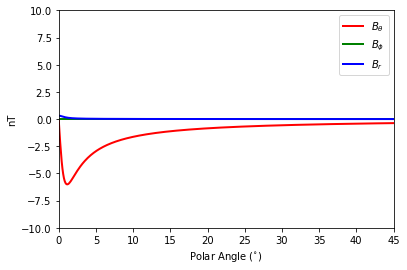

In [14]:
# generate plot similar to A&V-1999
plt.figure()
plt.plot(90-lats, pred * 1e9, linewidth=2)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

In [15]:
# For unit tests, estimate Btheta at 90 degrees colatitude, and Brad at 0 degrees colatitude
mu0 = 4 * np.pi * 1e-7 # N / A^2
Btheta90 = -(mu0 * 1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        (((6378000./(6378000+100000)) - np.cos(np.pi/2)) / \
         np.sqrt(1 - (2. * 6378000. * np.cos(np.pi/2)) / (6378000+100000) + \
                 (6378000/(6378000.+100000.))**2) + np.cos(np.pi/2))
Btheta90 += -(mu0 * -1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        ((6378000. - (6378000.-100000.) * np.cos(np.pi/2.)) / \
         np.sqrt(6378000.**2. - (2. * 6378000. * (6378000.-100000.) * np.cos(np.pi/2.)) + \
                 (6378000.-100000.)**2) - 1.)
    
Brad0 = (mu0 * 1e4) / (4. * np.pi * 6378000.) * \
       (1. / (np.sqrt(1. - 2. * 6378000 * np.cos(0.) / (6378000.+100000) + \
                     (6378000 / (6378000.+100000.))**2)) - 1. )
Brad0 += (mu0 * -1e4 * (6378000.-100000.)) / (4. * np.pi * 6378000.**2) * \
       (1. / (np.sqrt(1. - 2.*(6378000.-100000.) * np.cos(0.) / 6378000. + \
                     ((6378000.-100000.)/6378000.)**2)) - 1. )
    
print Btheta90 * 1e9
print pred[-1,0] * 1e9
print Brad0 * 1e9
print pred[0,2] * 1e9

-0.155050750539
-0.155050750539
0.311119646252
0.311119646252


## [Fitting SECs to Synthetic Data](#Contents:)

### Fitting Simple SEC Systems
We start by using predictions from the counter-SECs scenario above as perfect observations to fit two SECs, one above and one below the pole. We should get +/- 10,000 Amp SECs, exactly.

In [16]:
# fit the 2 SECs using perfect data, but assume 1nT uncertainty on observations
secsR_perfect = geomag_imp.secsRegressor(secs, 0.1)
secsR_perfect.fit(pred_llr, pred, np.ones(pred.shape) * 1e-9)

print secsR_perfect.secs_.amps
print np.sqrt(secsR_perfect.secs_.amps_var)

[ 10000. -10000.]
[ 286.46658513  299.97580929]


Next, add noise to those perfect observations then fit again. The solution is not perfect, but it is well within the 1-sigma statistical error bounds determined from singular value decomposition, as expected. In fact, if we repeated the following over and over (without re-seeding the random number generator of course), we would get exactly the same amps_var values each time, but a distribution of solutions that converged on means of 10,000 Amps, with standard deviations equal to the square root of the amps_var values.

In [17]:
# fit the 2 SECs using corrupted data with a 1nT sigma, and assume 1nT uncertainty on observations
rs = np.random.RandomState(0) # seed the random number generator for reproducibility
pred_errors = pred + rs.randn(*pred.shape) * 1e-9
secsR_error = geomag_imp.secsRegressor(secs, 0.1)
secsR_error.fit(pred_llr, pred_errors, np.ones(pred.shape) * 1e-9)

print secsR_error.secs_.amps
print np.sqrt(secsR_error.secs_.amps_var)

[  9750.51837154 -10118.38164046]
[ 286.46658513  299.97580929]


Finally, fit the SECs multiple times, but using just single observations. Do this once with epsilon set equal to zero, and once with epsilon equal to a finite value. Notice what happens to the solution, its uncertainty, and the singular values, especially at the pole and near 30 degrees latitude.

The zero-epsilon solutions return the expected values, except at the pole, where the solution is known to be non-unique. The uncertainty associated with these solutions seems to be a function of the latitude of the observation, with a peak near 30 degrees. It is not a simple function of distance from the observation.

The finite-epsilon solutions usually return the expected value. **Not** at the pole (although it does return **a** value here, which is interesting, if not immediately explainable), and **not** at 30 degrees, where the uncertainty normally maximizes. The uncertainty did not maximize at 30 degrees in this case because the SVD solution was actually truncated here. In other words, it is effectively a different (1st-order, not 2nd-order) model, and the estimated uncertainties are not comparable.

In [18]:
secsR_singles = geomag_imp.secsRegressor(secs, 0.0)
for i in range(len(pred)):
    if not i%100:
        # only process for polar angle increments of 10 degrees
        secsR_singles.fit([pred_llr[i]], [pred[i]], [np.ones(pred[i].shape) * 1e-9])
        print r"%2d: [%9.1f %9.1f]  [%9.1f %9.1f] [%9.2e %9.2e]"%(
            pred_llr[i][0],
            secsR_singles.secs_.amps[0],
            secsR_singles.secs_.amps[1],
            np.sqrt(secsR_singles.secs_.amps_var[0]),
            np.sqrt(secsR_singles.secs_.amps_var[1]),
            secsR_singles.S_[0],
            secsR_singles.S_[1]
        )

print
        
secsR_singles = geomag_imp.secsRegressor(secs, 0.1)
for i in range(len(pred)):
    if not i%100:
        # only process for polar angle increments of 10 degrees
        secsR_singles.fit([pred_llr[i]], [pred[i]], [np.ones(pred[i].shape) * 1e-9])
        print r"%2d: [%9.1f %9.1f]  [%9.1f %9.1f] [%9.2e %9.2e]"%(
            pred_llr[i][0],
            secsR_singles.secs_.amps[0],
            secsR_singles.secs_.amps[1],
            np.sqrt(secsR_singles.secs_.amps_var[0]),
            np.sqrt(secsR_singles.secs_.amps_var[1]),
            secsR_singles.S_[0],
            secsR_singles.S_[1]
        )

90: [      nan       nan]  [      inf       inf] [ 1.39e-03  0.00e+00]
80: [  10000.0  -10000.0]  [   8659.5    9609.2] [ 1.18e-04  1.02e-04]
70: [  10000.0  -10000.0]  [  18489.0   22899.3] [ 6.14e-05  4.08e-05]
60: [  10000.0  -10000.0]  [  32022.9   44918.8] [ 4.13e-05  2.02e-05]
50: [  10000.0  -10000.0]  [  55590.7   89142.1] [ 3.09e-05  1.00e-05]
40: [  10000.0  -10000.0]  [ 120688.3  220486.9] [ 2.44e-05  4.03e-06]
30: [  10000.0  -10000.0]  [2744248.2 5554977.8] [ 2.00e-05  1.61e-07]
20: [  10000.0  -10000.0]  [ 173240.7  366320.8] [ 1.67e-05  2.50e-06]
10: [  10000.0  -10000.0]  [ 105009.7  215439.4] [ 1.42e-05  4.37e-06]
 0: [  10000.0  -10000.0]  [  91507.4  172082.5] [ 1.22e-05  5.65e-06]

90: [    160.5     155.5]  [    515.8     499.8] [ 1.39e-03  0.00e+00]
80: [  10000.0  -10000.0]  [   8659.5    9609.2] [ 1.18e-04  1.02e-04]
70: [  10000.0  -10000.0]  [  18489.0   22899.3] [ 6.14e-05  4.08e-05]
60: [  10000.0  -10000.0]  [  32022.9   44918.8] [ 4.13e-05  2.02e-05]
50: [

/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:330: RuntimeWarning: divide by zero encountered in divide
  W = 1. / S_ # divide by Inf gives zero-weight
/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:335: RuntimeWarning: divide by zero encountered in divide
  self.secs_.amps_var = np.sum((self.Vh_.T / S_)**2, axis=1)


### Fitting Gridded SECs to "Measured" Geomagnetic Disturbance

Synthetic geomagnetic observations were inverted for a gridded SEC system. This SEC system was then used to interpolate magnetic disturbance onto a grid across North America. Gridded synthetic observations ("truth"), and inverted geomagnetic disturbances are compared. 

In summary:

1. Realistic geospace current distributions were generated using the Lyon-Fedder-Mobarry (LFM) global geospace circulation model. The LFM's current distribution includes:
  - 2D thin-sheet high-latitude (>30 degrees) ionosphere 
  - dipole-aligned field-aligned currents
  - magnetosphere, including realistic ring, tail, and magnetopause currents 
2. Simulated geospace currents are converted to synthetic ground magnetic perturbations using the Biot-Savart relationship;
3. Synthetic geomagnetic observations at USGS and NRCAN observatory locations are used to invert for a gridded SEC system.
4. Gridded synthetic geomagnetic disturbance is compared to gridded geomagnetic disturbance generated by SECs.

In [19]:
# load synthetic observations from PKL file(s) generated on NCAR supers;
# These should contain a list of dictionaries, each corresponding to a
# "synthetic observatory"; the synthetic observatory is a dictionary
# that contains (at least) the dictionaries: {'North', 'East', 'Down',
#  'thetaGEO', 'phiGEO', 'rhoGEO', 'datetime', 'obs'}, which are each 
# a dictionary that contains: {'name','unit','data'}, and 'data' is a 
# time-ordered sequence of vector components, location components, time
# stamps, and observatory labels, respectively)

# open and read pickle file
fh = open('data/StPatty_dBobs_dBTot_1h.pkl', 'rb')
dBTot = cPickle.load(fh)
fh.close()

# convert synthetic observations into data compatible with Geomag-IMP
# (i.e., instead of a list of time series, create a time series of lists
#  of observatories, with locations in lat (degrees), lon (degrees), and
#  radius (meters), direction vectors in southward, eastward, outward, 
#  and units of Tesla)
obs_lat_lon_r = []
obs_Btheta_Bphi_Br = []
obs_sigma_Btheta_Bphi_Br = []
for ob in dBTot:
    
    # observatory coordinates (lat (degrees, lon (degrees), radius (meters))
    obs_lat_lon_r.append(
        [
            90 - np.array(ob['thetaGEO']['data']) * 180./np.pi,
            np.array(ob['phiGEO']['data']) * 180./np.pi,
            np.array(ob['rhoGEO']['data'])
            
        ]
    )
        
    # magnetic perturbations in Tesla
    obs_Btheta_Bphi_Br.append(
        [
            -np.array(ob['North']['data']) * 1e-9,
             np.array(ob['East']['data']) * 1e-9,
            -np.array(ob['Down']['data']) * 1e-9
        ]
    )
    
    # magnetic perturbation sigmas
    obs_sigma_Btheta_Bphi_Br.append(
        [
            [1 if good else np.inf for good in np.isfinite(ob['North']['data'])],
            [1 if good else np.inf for good in np.isfinite(ob['East']['data'])],
            [np.inf if good else np.inf for good in np.isfinite(ob['Down']['data'])]
        ]
    )

# convert these lists to NumPy arrays with time index along axis 0
obs_lat_lon_r = np.transpose(obs_lat_lon_r, (2,0,1))
obs_Btheta_Bphi_Br = np.transpose(obs_Btheta_Bphi_Br, (2,0,1))
obs_sigma_Btheta_Bphi_Br = np.transpose(obs_sigma_Btheta_Bphi_Br, (2,0,1))

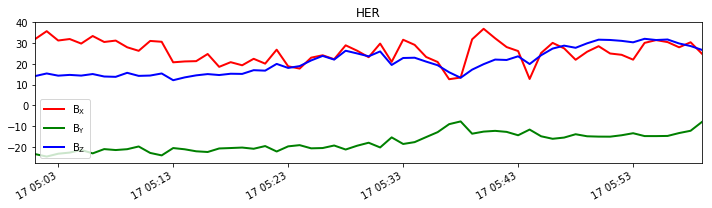

In [20]:
# Plot synthetic observatory time series

# configure output map file
plot_dir = 'data/Plots/'
plot_ext = '.png'
plot_dpi = 150

plt.figure(figsize=(10,3))
for ob in dBTot:
    
    plt.clf()
    
    plt.plot(ob['datetime']['data'], ob['North']['data'],
             linewidth=2)
    plt.plot(ob['datetime']['data'], ob['East']['data'],
             linewidth=2)
    plt.plot(ob['datetime']['data'], ob['Down']['data'],
             linewidth=2)
    plt.legend(['$\mathsf{B_X}$','$\mathsf{B_Y}$','$\mathsf{B_Z}$'], loc='lower left', prop={'size':10})
    plt.title(ob['obs']['name'])
    plt.gca().set_xlim([ob['datetime']['data'][1], ob['datetime']['data'][-1]])
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    
    # write to file
    baseName = 'LFM_RCM'
    plotFilename = plot_dir+baseName+"_"+ob['obs']['name']+plot_ext
    try:
        plt.savefig(plotFilename, dpi=plot_dpi)
    except IOError:
        # if plot_dir didn't exist, create and try again
        os.mkdir(plot_dir)
        plt.savefig(plotFilename, dpi=plot_dpi)

In [21]:
# load synthetic gridded data from PKL file(s) generated on NCAR supers;
# These should contain a list of dictionaries, each corresponding to a
# "synthetic observatory"; the "synthetic observatory" is a dictionary
# that contains (at least) dictionaries: {'North', 'East', 'Down',
#  'thetaGEO', 'phiGEO', 'rhoGEO', 'datetime', 'obs'}, which are each 
# a dictionary that contains: {'name','unit','data'}, and 'data' is a 
# time-ordered sequence of vector comonents, location components, time
# stamps, and observatory labels, respectively)

# open and read pickle file
fh = open('data/StPatty_dBgrid_dBTot_1h.pkl', 'rb')
dBTot = cPickle.load(fh)
fh.close()

# convert synthetic observations into data compatible with Geomag-IMP
# (i.e., instead of a list of time series, create a time series of lists
#  of observatories, with locations in lat (degrees), lon (degrees), and
#  radius (meters), direction vectors in southward, eastward, outward, 
#  and units of Tesla)
grid_lat_lon_r = []
grid_Btheta_Bphi_Br = []
grid_sigma_Btheta_Bphi_Br = []
for ob in dBTot:
    
    # observatory coordinates (lat (degrees, lon (degrees), radius (meters))
    grid_lat_lon_r.append(
        [
            90 - np.array(ob['thetaGEO']['data']) * 180./np.pi,
            np.array(ob['phiGEO']['data']) * 180./np.pi,
            np.array(ob['rhoGEO']['data'])
            
        ]
    )
        
    # magnetic perturbations in Tesla
    grid_Btheta_Bphi_Br.append(
        [
            -np.array(ob['North']['data']) * 1e-9,
             np.array(ob['East']['data']) * 1e-9,
            -np.array(ob['Down']['data']) * 1e-9
        ]
    )
    
    # magnetic perturbation sigmas
    grid_sigma_Btheta_Bphi_Br.append(
        [
            [1 if good else np.inf for good in np.isfinite(ob['North']['data'])],
            [1 if good else np.inf for good in np.isfinite(ob['East']['data'])],
            [np.inf if good else np.inf for good in np.isfinite(ob['Down']['data'])]
        ]
    )

# convert these lists to NumPy arrays with time index along axis 0
grid_lat_lon_r = np.transpose(grid_lat_lon_r, (2,0,1))
grid_Btheta_Bphi_Br = np.transpose(grid_Btheta_Bphi_Br, (2,0,1))
grid_sigma_Btheta_Bphi_Br = np.transpose(grid_sigma_Btheta_Bphi_Br, (2,0,1))

In [22]:
# construct SECS grid

Re = 6378e3 # Earth's radius in meters
Hi = 122e3 # height of ionosphere

# grid for SECs
secs_lat = (15,85,2) # min,max,delta tuple for SEC latitudes in degrees
secs_lon = (-175,-25,2) # min,max,delta tuple for SEC longitudes in degrees

# epsilon for truncated SVD
epsilon = 0.05

lat_tmp, lon_tmp, r_tmp = np.meshgrid(
  np.linspace(secs_lat[0], secs_lat[1],
              (secs_lat[1] - secs_lat[0]) / secs_lat[2] + 1),
  np.linspace(secs_lon[0], secs_lon[1],
              (secs_lon[1] - secs_lon[0]) / secs_lon[2] + 1),
  Re+Hi,
  indexing='ij'
)
secs_lat_lon_r = np.hstack(
  (lat_tmp.reshape(-1,1),
   lon_tmp.reshape(-1,1),
   r_tmp.reshape(-1,1))
)

# fit SECS to obserations and interpolate

# initialize regressor
imp = geomag_imp.secsRegressor(
    geomag_imp.secs(secs_lat_lon_r),
    epsilon
)

# generate a map for each time step
pred_Btheta_Bphi_Br = []
for tidx in np.arange(len(obs_Btheta_Bphi_Br)):
    
    # these element-wise comparisons help avoid re-calculation of various
    # imp attributes that would be much more computationally intensive
    if np.array_equal(grid_lat_lon_r[tidx],
                      imp.pred_lat_lon_r_):
        pred_llr = imp.pred_lat_lon_r_
    else:
        pred_llr = grid_lat_lon_r[tidx]
    
    if np.array_equal(obs_lat_lon_r[tidx],
                      imp.obs_lat_lon_r_):
        obs_llr = imp.obs_lat_lon_r_
    else:
        obs_llr = obs_lat_lon_r[tidx]
    
    if np.array_equal(obs_Btheta_Bphi_Br[tidx],
                      imp.obs_Btheta_Bphi_Br_):
        obs_Bt_Bp_Br = imp.obs_Btheta_Bphi_Br_
    else:
        obs_Bt_Bp_Br = obs_Btheta_Bphi_Br[tidx]
            
    if np.array_equal(obs_sigma_Btheta_Bphi_Br[tidx],
                      imp.obs_sigma_Btheta_Bphi_Br_):
        obs_sigma_Bt_Bp_Br = imp.obs_sigma_Btheta_Bphi_Br_
    else:
        obs_sigma_Bt_Bp_Br = obs_sigma_Btheta_Bphi_Br[tidx]


    # fit the observed data
    imp.fit(obs_llr, obs_Bt_Bp_Br,
            sigma_Btheta_Bphi_Br = obs_sigma_Bt_Bp_Br)

    # interpolate to prediction grid; append time series of predictions
    pred_Btheta_Bphi_Br.append(imp.predict(pred_llr))
    
# convert list to NumPy array
pred_Btheta_Bphi_Br = np.array(pred_Btheta_Bphi_Br)

### Plot Synthetic  vs. SECS-Predicted Gridded Vectors

In [23]:
#
# map related configuration parameters
#

# import scipy's interpolate sub-package
from scipy import interpolate as sInterp

# import Basemap to initialze maps
from mpl_toolkits.basemap import Basemap

# set up a Lambert Azimuthal equal area basemap for North America
mapH = 6000000 # encompasses most of N.A., South to North, in ~meters
mapW = 10000000 # encompasses all of N.A., East to West, and HON, in ~meters
lon_0 = 250. # central longitude
lat_0 = 50.  # central latitude
lat_ts = lat_0 # latitude of "true scale"

# set nx and ny to None if you want the original Lat/Lon grid
nx = 40 # number of interpolated points in map's X direction
ny = 24 # number of interpolated points in map's Y direction

# configure some map drawing preferences
land_color = 'lightgray'
water_color = 'white'
arrow_color = 'darkblue'
arrow_scale = 67
arrow_width = .003

# configure output map file
map_dir = 'data/Plots/'
map_ext = '.png'
map_dpi = 150

# if nx or ny is None, and the other is not, make nx=ny, or ny=nx
if nx is None and ny is not None:
  nx = ny
if ny is None and nx is not None:
  ny = nx

# convert *Btheta_Bphi_Br's to XYZ's for plotting
UTs = dBTot[0]['datetime']['data']
Lats = grid_lat_lon_r[:,:,0]
Lons = grid_lat_lon_r[:,:,1]
Rads = grid_lat_lon_r[:,:,2]
gXs = -grid_Btheta_Bphi_Br[:,:,0] * 1e9
gYs = grid_Btheta_Bphi_Br[:,:,1] * 1e9
gZs = -grid_Btheta_Bphi_Br[:,:,2] * 1e9
pXs = -pred_Btheta_Bphi_Br[:,:,0] * 1e9
pYs = pred_Btheta_Bphi_Br[:,:,1] * 1e9
pZs = -pred_Btheta_Bphi_Br[:,:,2] * 1e9

ObsLats = obs_lat_lon_r[:,:,0]
ObsLons = obs_lat_lon_r[:,:,1]
ObsRads = obs_lat_lon_r[:,:,2]
ObsXs = -obs_Btheta_Bphi_Br[:,:,0] * 1e9
ObsYs = obs_Btheta_Bphi_Br[:,:,1] * 1e9
ObsZs = -obs_Btheta_Bphi_Br[:,:,2] * 1e9

ObsFits = np.isfinite(ObsXs) & np.isfinite(ObsYs) & np.isfinite(ObsZs)

# calculate magnitudes, then convert Xs and Ys into unit vectors
gMs = [np.sqrt(X**2 + Y**2) for X,Y in zip(gXs,gYs)]
gXs = [X / M for X,M in zip(gXs,gMs)]
gYs = [Y / M for Y,M in zip(gYs,gMs)]
pMs = [np.sqrt(X**2 + Y**2) for X,Y in zip(pXs,pYs)]
pXs = [X / M for X,M in zip(pXs,pMs)]
pYs = [Y / M for Y,M in zip(pYs,pMs)]
ObsMs = [np.sqrt(X**2 + Y**2) for X,Y in zip(ObsXs,ObsYs)]
ObsXs = [X / M for X,M in zip(ObsXs,ObsMs)]
ObsYs = [Y / M for Y,M in zip(ObsYs,ObsMs)]

# convert Ms to Log10 scale; set negative log values to 0 (i.e., 1 nT)
gMs = [np.clip(np.log10(M), 0, np.Inf) for M in gMs]
pMs = [np.clip(np.log10(M), 0, np.Inf) for M in pMs]
ObsMs = [np.clip(np.log10(M), 0, np.Inf) for M in ObsMs]


59


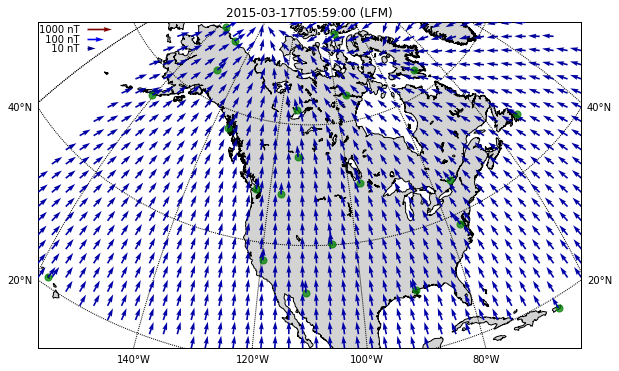

In [24]:
# Plot synthetic gridded and observations

# create a basemap
# bm = Basemap(width = mapW, height = mapH,
#            resolution = 'l', projection = 'laea',
#            lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)

# roughly keep default size, but force new aspect ratio to match map
#w,h = plt.figaspect(float(mapH)/float(mapW))
#plt.figure(figsize=(w,h))
plt.figure(figsize=(10,6))
for i,ut in enumerate(UTs):
    print "\r",i,

    # this needs to be re-instantiated each time, or else a RuntimeError
    # is generated in MPL>1.5...can not put a single artist in more than
    # one figure
    bm = Basemap(width = mapW, height = mapH,
           resolution = 'l', projection = 'laea',
           lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)
    plt.clf()
    
    bm.drawcoastlines()
    bm.fillcontinents(color = land_color, lake_color = water_color)
    # maybe parallels and meridians should be configurable (?)
    bm.drawparallels(np.arange(-80.,81.,20.), labels = [1,1,0,0])
    bm.drawmeridians(np.arange(-180.,181.,20.), labels = [0,0,0,1])
    bm.drawmapboundary(fill_color = water_color)

    if nx==None and ny==None:
        # vectors remain on input grid
        u,v,x,y = bm.rotate_vector(gYs[i] * gMs[i], gXs[i] * gMs[i],
                                   Lons[i], Lats[i],
                                   returnxy = True)

    else:
        # Basemap.transform_vector() does not generate results consistent
        # with Basemap.rotate_vector(). We re-implment transform_vector()
        # here, but call a different 2d interpolator.
        uin,vin,xin,yin = bm.rotate_vector(gYs[i] * gMs[i], gXs[i] * gMs[i],
                                           Lons[i], Lats[i],
                                           returnxy = True)
        longs, lats, x, y = bm.makegrid(nx, ny, returnxy = True)


        u = sInterp.griddata((xin.flatten(), yin.flatten()), uin.flatten(),
                             (x, y), method = 'linear')
        v = sInterp.griddata((xin.flatten(), yin.flatten()), vin.flatten(),
                             (x, y), method = 'linear')

    # plot vector field
    q = bm.quiver(x, y, u, v, 10 ** np.sqrt(u**2 + v**2),
                  scale = arrow_scale,
                  width = arrow_width,
                  cmap='jet',
                  clim = [1,1000],
                  zorder = 10)

    # NOTE: the following seems broken in MPL-1.4.2, but fixed by MPL-1.4.3
    plt.quiverkey(q, .09, .98, 3,
                  ('%4.0f '+'%s') % (10**3, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10.**3 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})
    plt.quiverkey(q, .09, .95, 2,
                  ('%4.0f '+'%s') % (10**2, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10**2 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})
    plt.quiverkey(q, .09, .92, 1,
                  ('%4.0f '+'%s') % (10**1, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10**1 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})

    # place green dots at observatory locations included in this map solution
    bm.scatter(ObsLons[i][ObsFits[i].astype(bool)],
               ObsLats[i][ObsFits[i].astype(bool)],
               latlon=True, zorder=10, color='green', s=50, alpha=0.75)

    # place red dots at observatory locations NOT included in this map solution
    bm.scatter(ObsLons[i][~ObsFits[i].astype(bool)],
               ObsLats[i][~ObsFits[i].astype(bool)],
               latlon=True, zorder=10, color='red', s=50, alpha=0.75)



    # place observation vectors over top green dots
    u,v,x,y = bm.rotate_vector(ObsYs[i] * ObsMs[i], ObsXs[i] * ObsMs[i],
                               ObsLons[i], ObsLats[i],
                               returnxy = True)
    bm.quiver(x, y, u, v, 10 ** np.sqrt(u**2 + v**2),
              scale = arrow_scale,
              width = arrow_width,
              cmap='jet',
              clim = [1,1000],
              zorder = 10)


    # labels
    plt.title(ut.isoformat()+' (LFM)')
    
    
    # write to file
    baseName = 'LFM_RCM'
    plotFilename = (plot_dir+baseName+"_%04d%02d%02dT%02d%02d%02d"%
                         (ut.year,ut.month,ut.day,ut.hour,ut.minute,ut.second)+map_ext)
    try:
        plt.savefig(plotFilename, dpi=map_dpi)
    except IOError:
        # if map_dir didn't exist, create and try again
        os.mkdir(map_dir)
        plt.savefig(plotFilename, dpi=map_dpi)


59


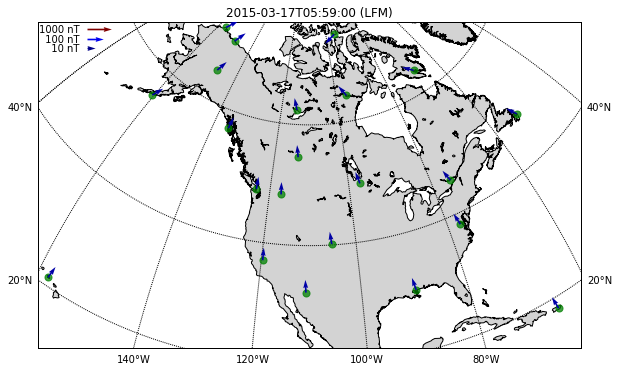

In [25]:
# Plot synthetic observations only

# create a basemap
# bm = Basemap(width = mapW, height = mapH,
#            resolution = 'l', projection = 'laea',
#            lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)

# roughly keep default size, but force new aspect ratio to match map
#w,h = plt.figaspect(float(mapH)/float(mapW))
#plt.figure(figsize=(w,h))
plt.figure(figsize=(10,6))
for i,ut in enumerate(UTs):
    print "\r",i,
    
    # this needs to be re-instantiated each time, or else a RuntimeError
    # is generated in MPL>1.5...can not put a single artist in more than
    # one figure
    bm = Basemap(width = mapW, height = mapH,
           resolution = 'l', projection = 'laea',
           lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)
    plt.clf()
    
    # NOTE: all this seems to break in MPL > 1.5...some error about 
    # "RuntimeError: Can not put single artist in more than one figure"
    # ...for now just use MPL v1.4.3 -EJR 5/2017
    bm.drawcoastlines()
    bm.fillcontinents(color = land_color, lake_color = water_color)
    # maybe parallels and meridians should be configurable (?)
    bm.drawparallels(np.arange(-80.,81.,20.), labels = [1,1,0,0])
    bm.drawmeridians(np.arange(-180.,181.,20.), labels = [0,0,0,1])
    bm.drawmapboundary(fill_color = water_color)


    # place green dots at observatory locations included in this map solution
    bm.scatter(ObsLons[i][ObsFits[i].astype(bool)],
               ObsLats[i][ObsFits[i].astype(bool)],
               latlon=True, zorder=10, color='green', s=50, alpha=0.75)

    # place red dots at observatory locations NOT included in this map solution
    bm.scatter(ObsLons[i][~ObsFits[i].astype(bool)],
               ObsLats[i][~ObsFits[i].astype(bool)],
               latlon=True, zorder=10, color='red', s=50, alpha=0.75)



    # place observation vectors over top green dots
    u,v,x,y = bm.rotate_vector(ObsYs[i] * ObsMs[i], ObsXs[i] * ObsMs[i],
                               ObsLons[i], ObsLats[i],
                               returnxy = True)
    q = bm.quiver(x, y, u, v, 10 ** np.sqrt(u**2 + v**2),
              scale = arrow_scale,
              width = arrow_width,
              cmap='jet',
              clim = [1,1000],
              zorder = 10)

    
    # NOTE: the following seems broken in MPL-1.4.2, but fixed by MPL-1.4.3
    plt.quiverkey(q, .09, .98, 3,
                  ('%4.0f '+'%s') % (10**3, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10.**3 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})
    plt.quiverkey(q, .09, .95, 2,
                  ('%4.0f '+'%s') % (10**2, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10**2 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})
    plt.quiverkey(q, .09, .92, 1,
                  ('%4.0f '+'%s') % (10**1, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10**1 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})

    # labels
    plt.title(ut.isoformat()+' (LFM)')
    
    
    # write to file
    baseName = 'LFM_RCM_ObsOnly'
    plotFilename = (plot_dir+baseName+"_%04d%02d%02dT%02d%02d%02d"%
                         (ut.year,ut.month,ut.day,ut.hour,ut.minute,ut.second)+map_ext)
    try:
        plt.savefig(plotFilename, dpi=map_dpi)
    except IOError:
        # if plot_dir didn't exist, create and try again
        os.mkdir(map_dir)
        plt.savefig(plotFilename, dpi=map_dpi)


59


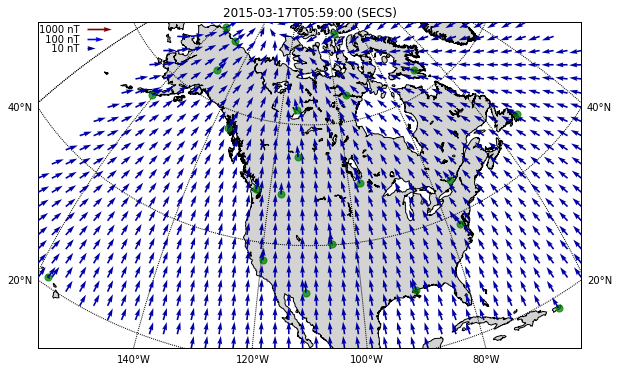

In [26]:
# Plot synthetic SECS-gridded and observations

# create a basemap
# bm = Basemap(width = mapW, height = mapH,
#            resolution = 'l', projection = 'laea',
#            lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)

# roughly keep default size, but force new aspect ratio to match map
#w,h = plt.figaspect(float(mapH)/float(mapW))
#plt.figure(figsize=(w,h))
plt.figure(figsize=(10,6))
for i,ut in enumerate(UTs):
    print "\r",i,
    
    # this needs to be re-instantiated each time, or else a RuntimeError
    # is generated in MPL>1.5...can not put a single artist in more than
    # one figure
    bm = Basemap(width = mapW, height = mapH,
           resolution = 'l', projection = 'laea',
           lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)
    plt.clf()
    
    # NOTE: all this seems to break in MPL > 1.5...some error about 
    # "RuntimeError: Can not put single artist in more than one figure"
    # ...for now just use MPL v1.4.3 -EJR 5/2017
    bm.drawcoastlines()
    bm.fillcontinents(color = land_color, lake_color = water_color)
    # maybe parallels and meridians should be configurable (?)
    bm.drawparallels(np.arange(-80.,81.,20.), labels = [1,1,0,0])
    bm.drawmeridians(np.arange(-180.,181.,20.), labels = [0,0,0,1])
    bm.drawmapboundary(fill_color = water_color)

    if nx==None and ny==None:
        # vectors remain on input grid
        u,v,x,y = bm.rotate_vector(pYs[i] * pMs[i], pXs[i] * pMs[i],
                                   Lons[i], Lats[i],
                                   returnxy = True)

    else:
        # Basemap.transform_vector() does not generate results consistent
        # with Basemap.rotate_vector(). We re-implment transform_vector()
        # here, but call a different 2d interpolator.
        uin,vin,xin,yin = bm.rotate_vector(pYs[i] * pMs[i], pXs[i] * pMs[i],
                                           Lons[i], Lats[i],
                                           returnxy = True)
        longs, lats, x, y = bm.makegrid(nx, ny, returnxy = True)


        u = sInterp.griddata((xin.flatten(), yin.flatten()), uin.flatten(),
                             (x, y), method = 'linear')
        v = sInterp.griddata((xin.flatten(), yin.flatten()), vin.flatten(),
                             (x, y), method = 'linear')

    # plot vector field
    q = bm.quiver(x, y, u, v, 10 ** np.sqrt(u**2 + v**2),
                  scale = arrow_scale,
                  width = arrow_width,
                  cmap='jet',
                  clim = [1,1000],
                  zorder = 10)

    # NOTE: the following seems broken in MPL-1.4.2, but fixed by MPL-1.4.3
    plt.quiverkey(q, .09, .98, 3,
                  ('%4.0f '+'%s') % (10**3, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10.**3 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})
    plt.quiverkey(q, .09, .95, 2,
                  ('%4.0f '+'%s') % (10**2, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10**2 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})
    plt.quiverkey(q, .09, .92, 1,
                  ('%4.0f '+'%s') % (10**1, 'nT'),
                  coordinates='axes', labelpos='W',
                  color=q.get_cmap()((10**1 - q.get_clim()[0]) /
                                     np.float(q.get_clim()[1] - q.get_clim()[0]) ),
                  fontproperties={'size':10})

    # place green dots at observatory locations included in this map solution
    bm.scatter(ObsLons[i][ObsFits[i].astype(bool)],
               ObsLats[i][ObsFits[i].astype(bool)],
               latlon=True, zorder=10, color='green', s=50, alpha=0.75)

    # place red dots at observatory locations NOT included in this map solution
    bm.scatter(ObsLons[i][~ObsFits[i].astype(bool)],
               ObsLats[i][~ObsFits[i].astype(bool)],
               latlon=True, zorder=10, color='red', s=50, alpha=0.75)



    # place observation vectors over top green dots
    u,v,x,y = bm.rotate_vector(ObsYs[i] * ObsMs[i], ObsXs[i] * ObsMs[i],
                               ObsLons[i], ObsLats[i],
                               returnxy = True)
    bm.quiver(x, y, u, v, 10 ** np.sqrt(u**2 + v**2),
              scale = arrow_scale,
              width = arrow_width,
              cmap='jet',
              clim = [1,1000],
              zorder = 10)


    # labels
    plt.title(ut.isoformat()+' (SECS)')   
    
    
    # write to file
    baseName = 'LFM_RCM_SECS'
    plotFilename = (plot_dir+baseName+"_%04d%02d%02dT%02d%02d%02d.png"%
                         (ut.year,ut.month,ut.day,ut.hour,ut.minute,ut.second))
    try:
        plt.savefig(plotFilename, dpi=150)
    except IOError:
        # if plot_dir didn't exist, create and try again
        os.mkdir(plot_dir)
        plt.savefig(plotFilename, dpi=150)


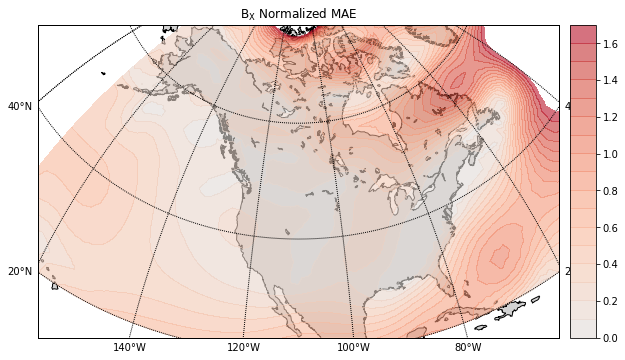

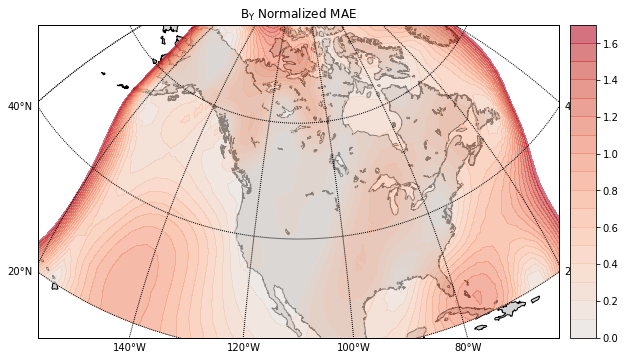

In [27]:
# calculate and plot gridded prediction metrics for magnetic maps 
# over the course of St. Patty Day storm

# start by pre-defining colormaps
from matplotlib.colors import LinearSegmentedColormap
cmap = plt.get_cmap('coolwarm')
cmapl = LinearSegmentedColormap.from_list('Lower Half', cmap(np.linspace(0,0.5, cmap.N//2)))
cmapu = LinearSegmentedColormap.from_list('Upper Half', cmap(np.linspace(0.5,1, cmap.N//2)))

# gridded error time series
err_Btheta_Bphi_Br = (grid_Btheta_Bphi_Br - pred_Btheta_Bphi_Br)


# vector component normalized Mean Absolute Errors
# (technically, it differs from nRMSE...said to be more interpretable...
#  ...effectively it is nMRSE)
nmae_Btheta = (np.nanmean(np.abs(err_Btheta_Bphi_Br[:,:,0]), axis=0) /
               np.nanstd(grid_Btheta_Bphi_Br[:,:,0], axis=0))
nmae_Btheta = np.ma.array(nmae_Btheta, mask = np.isnan(nmae_Btheta))
nmae_Bphi = (np.nanmean(np.abs(err_Btheta_Bphi_Br[:,:,1]), axis=0) /
             np.nanstd(grid_Btheta_Bphi_Br[:,:,1], axis=0))
nmae_Bphi = np.ma.array(nmae_Bphi, mask = np.isnan(nmae_Bphi))
nmae_Br = (np.nanmean(np.abs(err_Btheta_Bphi_Br[:,:,2]), axis=0) /
           np.nanstd(grid_Btheta_Bphi_Br[:,:,2], axis=0))
nmae_Br = np.ma.array(nmae_Br, mask = np.isnan(nmae_Br))


plt.figure(figsize=(10,6))
# create a basemap
bm = Basemap(width = mapW, height = mapH,
           resolution = 'l', projection = 'laea',
           lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)
bm.drawcoastlines()
bm.fillcontinents(color = land_color, lake_color = water_color)
bm.drawparallels(np.arange(-80.,81.,20.), labels = [1,1,0,0])
bm.drawmeridians(np.arange(-180.,181.,20.), labels = [0,0,0,1])
bm.drawmapboundary(fill_color = water_color)
x, y = bm(Lons[0], Lats[0])
c = bm.contourf(x, y, nmae_Btheta, tri=True,
                levels=[i/10. for i in range(18)], vmin=0, vmax=1.7,
                zorder=2, alpha=0.6, cmap=cmapu)
bm.colorbar(c)
plt.title('$\mathsf{B_{X}}$ Normalized MAE')

# write to file
baseName = 'LFM_RCM_secs'
plotFilename = (plot_dir+"mae_BX.png")
try:
    plt.savefig(plotFilename, dpi=150)
except IOError:
    # if plot_dir didn't exist, create and try again
    os.mkdir(plot_dir)
    plt.savefig(plotFilename, dpi=150)


plt.figure(figsize=(10,6))
# create a basemap
bm = Basemap(width = mapW, height = mapH,
           resolution = 'l', projection = 'laea',
           lat_ts = lat_ts, lat_0 = lat_0, lon_0 = lon_0)
bm.drawcoastlines()
bm.fillcontinents(color = land_color, lake_color = water_color)
bm.drawparallels(np.arange(-80.,81.,20.), labels = [1,1,0,0])
bm.drawmeridians(np.arange(-180.,181.,20.), labels = [0,0,0,1])
bm.drawmapboundary(fill_color = water_color)
x, y = bm(Lons[0], Lats[0])
c = bm.contourf(x, y, nmae_Bphi, tri=True,
                levels=[i/10. for i in range(18)], vmin=0, vmax=1.7,
                zorder=2, alpha=0.6, cmap=cmapu)
bm.colorbar(c)
plt.title('$\mathsf{B_{Y}}$ Normalized MAE')

# write to file
baseName = 'LFM_RCM_secs'
plotFilename = (plot_dir+"mae_BY.png")
try:
    plt.savefig(plotFilename, dpi=150)
except IOError:
    # if plot_dir didn't exist, create and try again
    os.mkdir(plot_dir)
    plt.savefig(plotFilename, dpi=150)


# plt.figure(figsize=(10,6))
# bm.drawcoastlines()
# bm.fillcontinents(color = land_color, lake_color = water_color)
# bm.drawparallels(np.arange(-80.,81.,20.), labels = [1,1,0,0])
# bm.drawmeridians(np.arange(-180.,181.,20.), labels = [0,0,0,1])
# bm.drawmapboundary(fill_color = water_color)
# x, y = bm(Lons[0], Lats[0])
# c = bm.contourf(x, y, nmae_Br, tri=True,
#                 levels=[i/10. for i in range(18)], vmin=0, vmax=1.7,
#                 zorder=2, alpha=0.6, cmap='rainbow')
# bm.colorbar(c)
# plt.title('$\mathsf{B_{Z}}$ Normalized MAE')



## Fitting SECs to Real Data

For now, the USGS is not generating real time XYZF disturbance data (i.e., baseline removed). The script make_svsqdist.py, included with this package, pulls the inputs necesary to do this, but it is too complicated to re-implement in a Notebook.

If/when the USGS makes XYZF disturbance data avaialble directly through its Edge servers, it would be worthwhile to insert a few cells here that demonstrate how one uses this module to generate an interpolated map.

In the meantime, users are encouraged to experiment with the command-line demonstration scripts stored int he bin/ folder of geomag-imp package.